In [1]:
# nEpochs=20  # orig, longer training
nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = True
USE_CVAE = False
USE_CVAECGAN = False

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception("Double check you are only using one model. The current model name is invalid")

%cd ./HPO

/project/nanocourse/SWE_OOP/train08/repos/Module_2_ArmandRathgeb/HPO


## 1. Import 3rd party libraries 

In [2]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[0], 
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    #)
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

2025-05-29 16:23:09.909712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748553789.932446    2512 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748553789.939491    2512 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748553789.957367    2512 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748553789.957386    2512 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748553789.957389    2512 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748553794.592791    2512 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15494 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
I0000 00:00:1748553794.593313    2512 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15506 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


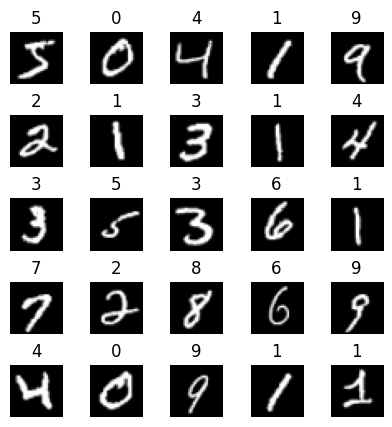

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
#model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
#if USE_CVAE or USE_CVAECGAN:
#    model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
#if USE_CGAN or USE_CVAECGAN:
#    model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.gan_SOLUTIONS
Loaded version: vaegan.gan_SOLUTIONS


In [5]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,))
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


Model: "cgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator (Generator)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Discriminator)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator                   │ ?                      │   0 (unbuilt) │
│ (MultiTaskDiscriminator)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== GENERATOR SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 8192)           │       122,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_dense_to_conv        │ (None, 8192)           │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu1 (Activation)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu0 (Activation)        │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,577 (2.47 MB)

 Trainable params: 648,577 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

=== DISCRIMINATOR SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        544 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        128 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     32,832 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_real (Dense)  │ (None, 1)         │     16,385 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_class (Dense) │ (None, 10)        │    163,850 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_real        │ (None, 1)         │          0 │ dense_real[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_class       │ (None, 10)        │          0 │ dense_class[0][0] │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,995 (835.92 KB)

 Trainable params: 213,803 (835.17 KB)

 Non-trainable params: 192 (768.00 B)

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'cgan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1748553797.995737    2512 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/3


I0000 00:00:1748553801.856144    2773 service.cc:152] XLA service 0x2aaea4012160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748553801.856190    2773 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748553801.856195    2773 service.cc:160]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/469 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - disc_loss: 4.1877 - gen_loss: 3.0257 - top_1_acc: 0.0859  

I0000 00:00:1748553808.741891    2773 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - disc_loss: 2.2345 - gen_loss: 2.5161 - top_1_acc: 0.4720
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - disc_loss: 1.0810 - gen_loss: 0.2230 - top_1_acc: 0.8756
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - disc_loss: 1.4276 - gen_loss: 0.6891 - top_1_acc: 0.9104


## 8. Training saves results to disk, now also plot training curves

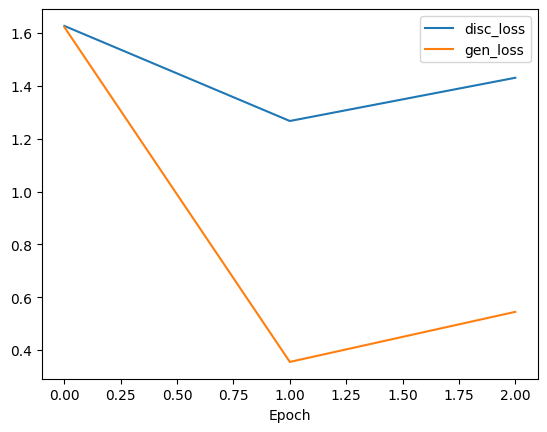

In [11]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss', 'recon_loss', 'kl_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+".keras"))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


In [10]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
tf.random.set_seed(1234)
## !!!!IMPORTANT!!!!


# Instantiate a container with the hyperparameter(s) you want to test


# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.

# Build a model with input / output dimensions

# Compile the model

# Fit model to the data

# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.
